## Imports

In [7]:
import os
import h5py
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dropout, BatchNormalization, Dense, GlobalAveragePooling1D
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Constants

In [12]:
DOWNSAMPLING_STEP = 4
NUM_CLASSES = 4

ENCODE_MAP = {
        'rest': 0,
        'motor': 1,
        'memory': 2,
        'math': 3,
    }

## Load data

In [13]:
def get_dataset_name(filename_with_dir):
    filename_without_dir = filename_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = '_'.join(temp)
    return dataset_name

def extract_label(filename, logs=False, encode_mapping=ENCODE_MAP):
    if 'rest' in filename:
        print(f'Mapping label {filename} to {encode_mapping["rest"]}') if logs else None
        return encode_mapping['rest']
    elif 'motor' in filename:
        print(f'Mapping label {filename} to {encode_mapping["motor"]}') if logs else None
        return encode_mapping['motor']
    elif 'memory' in filename:
        print(f'Mapping label {filename} to {encode_mapping["memory"]}') if logs else None
        return encode_mapping['memory']
    else:
        print(f'Mapping label {filename} to {encode_mapping["math"]}') if logs else None
        return encode_mapping['math']

def load_all_data(folder_path, logs=False):
    X = []
    y = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.h5'):
            print(f"Loading {filename}...") if logs else None
            file_path = os.path.join(folder_path, filename)
            with h5py.File(file_path, 'r') as f:
                dataset_name = get_dataset_name(file_path)
                data = f.get(dataset_name)[()]
                label = extract_label(filename)
                print(f"Data shape: {data.shape}, label: {label}") if logs else None
                X.append(data)       # shape (248, 35624)
                y.append(label)      # 'motor', 'rest', etc.
    X = np.array(X)  # shape (n_samples, 248, 35624)
    y = np.array(y)  # shape (n_samples,)
    return X, y

## Preprocessing

In [14]:
def z_score_normalize(data):
    # data: shape (248, T)
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True) + 1e-8
    return (data - mean) / std


def downsample(data, step=DOWNSAMPLING_STEP):
    # data: shape (248, T)
    return np.array(data[:, ::step])  # keep every 8th column

In [15]:
# Specify the folder name and load the data. (Don't push data folders to GitHub!!!)
X_train, y_train = load_all_data("Intra/train", logs=0)
print(f"X_train shape before preprocessing {np.array(X_train).shape}")  # 3D array: (n_samples, n_channels, n_times)
print(y_train)
X_train = [downsample(z_score_normalize(x)) for x in X_train]
X_train = np.array(X_train)  # shape (n_samples, n_channels, n_times)
print(f"X_train shape after preprocessing {np.array(X_train).shape}")  # 3D array: (n_samples, n_channels, n_times)

X_train shape before preprocessing (32, 248, 35624)
[0 3 1 3 3 2 1 0 0 2 1 0 1 2 1 0 0 1 2 3 1 2 1 2 0 0 2 3 3 3 2 3]
X_train shape after preprocessing (32, 248, 8906)


## CNN Model only

In [16]:
time_steps = X_train.shape[1]
num_channels = X_train.shape[2]


if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
print(y_train.shape)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

cnn_model = Sequential([
    Conv1D(64, 3, activation="relu", padding="same", input_shape=(time_steps, num_channels)),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(128, 5, activation="relu", padding="same"),
    BatchNormalization(),
    Dropout(0.2),

    GlobalAveragePooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')
])

cnn_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

(32, 4)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
history = cnn_model.fit(
    X_train, y_train,   
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3200 - loss: 1.3825 - val_accuracy: 0.2857 - val_loss: 1.3888
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5200 - loss: 1.2984 - val_accuracy: 0.0000e+00 - val_loss: 1.3910
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4400 - loss: 1.1844 - val_accuracy: 0.2857 - val_loss: 1.3922
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6800 - loss: 1.0737 - val_accuracy: 0.2857 - val_loss: 1.3927
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7200 - loss: 1.0119 - val_accuracy: 0.2857 - val_loss: 1.3915
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7600 - loss: 0.8844 - val_accuracy: 0.2857 - val_loss: 1.3913


## Testing and evaluating part

In [18]:
# Load and preprocess test data
X_test, y_test = load_all_data("Intra/test", logs=0)
print(f"X_test shape before preprocessing: {np.array(X_test).shape}")

X_test = [downsample(z_score_normalize(x), step=4) for x in X_test]
X_test = np.array(X_test)
print(f"X_test shape after preprocessing: {np.array(X_test).shape}")

# One-hot encode labels
y_test = to_categorical(y_test, num_classes=4)

X_test shape before preprocessing: (8, 248, 35624)
X_test shape after preprocessing: (8, 248, 8906)


In [19]:
# Evaluate
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2500 - loss: 1.3865
Test accuracy: 0.25


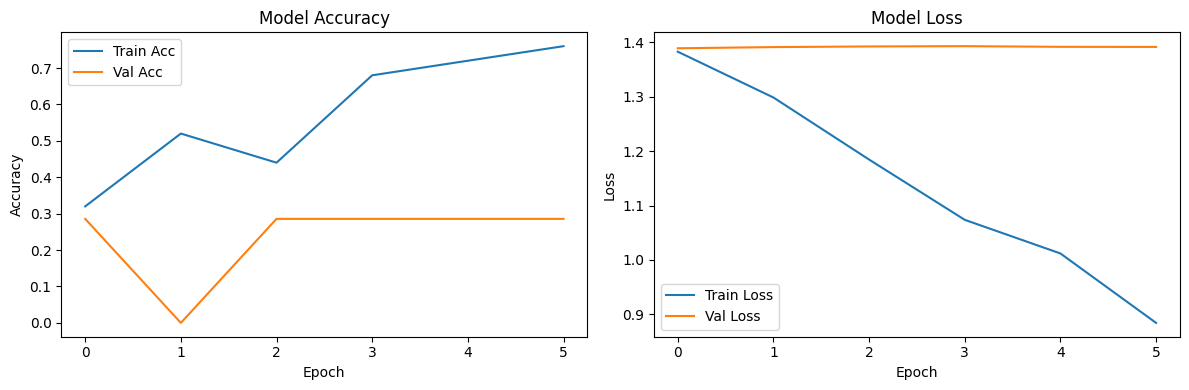

In [20]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


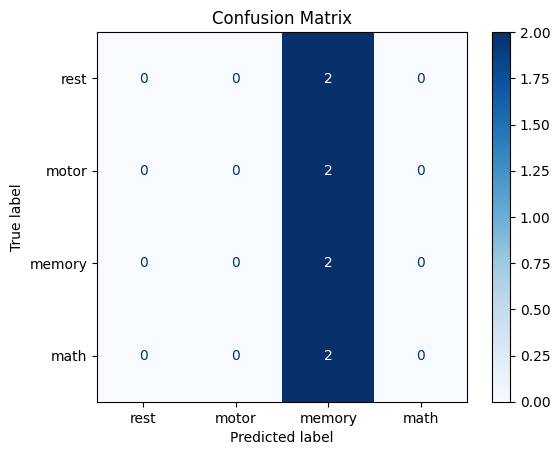

In [22]:
# Predict class probabilities
y_pred_probs = cnn_model.predict(X_test)
# Convert one-hot back to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rest", "motor", "memory", "math"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
